# Motivation

As part of our Prediction of Text difficulty problem, we are going to first start with the Feature engineering, followed by Unsupervised learning algorithms to check for themes in the text corpus and find clusters. At the very end, through our learnings from these various blocks, we will try creating a text classification model

# Contents in the notebook

The following Jupyter notebook is created to help us approach the problem of 'Prediction of Text difficulty'. We will be utilizing the resources that the MADS faculty provided in the Kaggle system. 

Through out this notebook, we will follow this sequence - First, we will take the external source provided by the faculty. Then we will use libraries like Spacy, NLTK to evaluate if the external datasources help our cause in identification of a theme between 'Sentences that needs correction' vs. 'Sentences that doesn't need correction'

In [ ]:
# Import libraries

import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import random
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid") # Setting the seaborn theme as 'darkgrid'
from collections import Counter, defaultdict
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from sklearn.naive_bayes import BernoulliNB
import scipy.stats as stats
from scipy.stats import norm
from scipy import sparse
from tqdm import tqdm
from zipfile import ZipFile
import os
import pickle
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk import pos_tag,pos_tag_sents
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.test.utils import datapath
from gensim.parsing.preprocessing import preprocess_documents
import spacy
from spacy import displacy
from collections import Counter
from joblib import Parallel, delayed

RANDOM_SEED=7007

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
nltk.download('stopwords')

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Unzip the contents of the zip file shared in kaggle and store them in a common location

file_name='/content/drive/Shareddrives/MADS_Milestone2_Drive/Data/umich-siads-695-predicting-text-difficulty.zip'
Data_unzipd='/content/drive/Shareddrives/MADS_Milestone2_Drive/Data_unzipd'


zp_file = ZipFile(file_name, 'r')
zp_file.extractall('Data_unzipd')
zp_file.close()

n=140
print("#" * n)
print('Names of the unzipped folder contents ')
os.listdir("/content/drive/Shareddrives/MADS_Milestone2_Drive/Data_unzipd/")

############################################################################################################################################
Names of the unzipped folder contents 


['AoA_51715_words.csv',
 'sampleSubmission.csv',
 'Concreteness_ratings_Brysbaert_et_al_BRM.txt',
 'additional_resource_file_readme.txt',
 'dale_chall.txt',
 'WikiLarge_Test.csv',
 'WikiLarge_Train.csv']

# Importing the requirements

We have access to the following data sources -

## Dale Chall text file

*   Dale chall word set : A set of ~3000 elementary English words that are typically familiar with 80% of American 4th Grade students. The words are created in 90's - We are not sure if there is a revised list, but we will use them for our analysis


In [ ]:
with open('/content/drive/Shareddrives/MADS_Milestone2_Drive/Data_unzipd/dale_chall.txt') as f:
    dale_chall_text = f.readlines()

In [ ]:
dale_chall = {i.strip('\n') for i in dale_chall_text}

## Average Age of Acquisition (AoA)

List of approximate age (In years) when a word was learned, for 50k English words.
This file contains "Age of Acquisition" (AoA) estimates for about 51k English words, which refers to the approximate age (in years) when a word was learned. Early words, being more basic, have lower average AoA.

The main columns you will be interested in are "Word" and "AoA_Kup_lem". But the others may be useful too.

The file contains these columns:

1. Word :: The word in question
2. Alternative.spelling :: if the Word may be spelled frequently in another form	
3. Freq_pm	:: Freq of the Word in general English (larger -> more common)
4. Dom_PoS_SUBTLEX	:: Dominant part of speech in general usage
5. Nletters :: number of letters 
6. Nphon :: number of phonemes
7. Nsyll :: number of syllables
8. Lemma_highest_PoS :: the "lemmatized" or "root" form of the word (in the dominant part of speech. e.g. The root form of the verb "abates" is "abate".
9. AoA_Kup	:: The AoA from a previous study by Kuperman et al.
10. Perc_known :: Percent of people who knew the word in the Kuperman et al. study
11. AoA_Kup_lem :: Estimated AoA based on Kuperman et al. study lemmatized words. THIS IS THE MAIN COLUMN OF INTEREST.
12. Perc_known_lem	:: Estimated percentage of people who would know this form of the word in the Kuperman study.
13. AoA_Bird_lem :: AoA reported in previous study by Bird (2001) 
14. AoA_Bristol_lem	:: AoA reported in previous study from Bristol Univ. (2006)
15. AoA_Cort_lem :: AoA reported in previous study by Cortese & Khanna (2008)
16. AoA_Schock :: AoA reported in previous study by Schock (2012)

In [ ]:
#Find the encoding of the file

import chardet    
rawdata = open('/content/drive/Shareddrives/MADS_Milestone2_Drive/Data_unzipd/AoA_51715_words.csv', 'rb').read()
result = chardet.detect(rawdata)
charenc = result['encoding']
print(charenc)

Windows-1252


In [ ]:
AOA = pd.read_csv('/content/drive/Shareddrives/MADS_Milestone2_Drive/Data_unzipd/AoA_51715_words.csv',encoding = 'Windows-1252')

In [ ]:
#Scan the top records - Only the AoA_Kup_Lem is the useful column in the entire dataset - We are filtering for these columns
AOA['AoA_Kup_lem'] = AOA['AoA_Kup_lem'].fillna(0)
AOA_SUB = AOA[['Alternative.spelling','AoA_Kup_lem']]

In [ ]:
AOA_SUB.head()

,Alternative.spelling,AoA_Kup_lem
0,a,2.89
1,aardvark,9.89
2,abacus,8.69
3,abacuses,8.69
4,abalone,12.23


## Import Concreteness ratings

This file contains concreteness ratings for 40 thousand English lemma words gathered via Amazon Mechanical Turk. The ratings come from a larger list of 63 thousand words and represent all English words known to 85% of the raters.

The file contains eight columns:
1. The word
2. Whether it is a single word or a two-word expression 
3. The mean concreteness rating
4. The standard deviation of the concreteness ratings
5. The number of persons indicating they did not know the word
6. The total number of persons who rated the word
7. Percentage participants who knew the word
8. The SUBTLEX-US frequency count (on a total of 51 million; Brysbaert & New, 2009) 
9. The dominant part-of-speech usage



In [ ]:
concreteness = pd.read_csv('/content/drive/Shareddrives/MADS_Milestone2_Drive/Data_unzipd/Concreteness_ratings_Brysbaert_et_al_BRM.txt',delimiter="\t")

In [ ]:
concreteness.head()

,Word,Bigram,Conc.M,Conc.SD,Unknown,Total,Percent_known,SUBTLEX,Dom_Pos
0,roadsweeper,0,4.85,0.37,1,27,0.96,0,0
1,traindriver,0,4.54,0.71,3,29,0.90,0,0
2,tush,0,4.45,1.01,3,25,0.88,66,0
3,hairdress,0,3.93,1.28,0,29,1.00,1,0
4,pharmaceutics,0,3.77,1.41,4,26,0.85,0,0


We will be utilizing the Percent_known for our future reference

## Import Wiki text corpus

Background (shared by the Kaggle page) : In many real-world applications, there is a need to make sure textual information is comprehensible/readable by audiences who may not have high reading proficiency. This might include students, children, adults with learning/reading difficulties, and those who have English as a second language. The simple Wikipedia (https://en.wikipedia.org/wiki/Simple_English_Wikipedia), for example, was created exactly for this purpose. Before the editors spend a lot of effort to simplify the text and increase its readability, it would be very useful to suggest to them which parts of an article's text might need to be simplified.

Our goal is to classify each document (sentence) into ONE of two categories, based on whether it needs to be simplified.

* 0: the sentence does NOT need to be simplified
* 1: the sentence DOES need to be simplified

The training data contains 416,768 sentences, already labeled with one of the above categories. The test data contains 119,092 comments that are unlabeled. The submission should be a .csv (comma separated free text) file with a header line "ID,Category" followed by exactly 119,092 lines

In [ ]:
# Inspect docs

train_df_1=pd.read_csv('/content/drive/Shareddrives/MADS_Milestone2_Drive/Data_unzipd/WikiLarge_Train.csv')

n=140
print("#" * n)
print('Shape of the training data set')
print(train_df_1.shape)

print("#" * n)
print('Initial content of the training data set')
print(train_df_1.sample(5))

test_df_1=pd.read_csv('/content/drive/Shareddrives/MADS_Milestone2_Drive/Data_unzipd/WikiLarge_Test.csv')

n=140
print("#" * n)
print('Shape of the test data set')
print(test_df_1.shape)

print("#" * n)
print('Initial content of the test data set')
print(test_df_1.sample(5))

############################################################################################################################################
Shape of the training data set
(416768, 2)
############################################################################################################################################
Initial content of the training data set
                                            original_text  label
85596   For some time , the song ranked number 1 among...      1
290801  Piltene is a town in Latvia with town rights s...      0
31356   The preliminary rounds were filmed in five cit...      1
159327  Overall , '' â -LRB- a -RRB- verage earnings r...      1
166052                                             OMIM =      1
############################################################################################################################################
Shape of the test data set
(119092, 3)
################################################################

In [ ]:
#Let's first get the stop words from Spacy as well
sp = spacy.load('en_core_web_sm')
stopwords = sp.Defaults.stop_words

# Start experiments

Let's first see how the Named entities are in both the groups of sentences. We will use SPACY pipeline over the next steps. Spacy pipeline is faster - However, be sure to disable the funcationalities that you wouldn't be using for your usecase - it will improve the run times significantly. More about how we can optimize Spacy is [here](https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html) 

We will also use joblib to utilize the parallel cores of the system

## Add Named entities

In [ ]:
#To make this code run faster, we will use job lib functionalities of parallel 
#processing. Across the code chunks, the commenting will help you understand
#the process

#Only include the functionalities that you need in the pipeline. It used a pre-
#defined model in Spacy to tag the named entities. This may not be the best possible
#model but, we want to check what happens if we actually look for Named entities
nlp = spacy.load('en_core_web_sm', disable=['tagger','parser'])
nlp.pipe_names

#The function takes a doc as object and looks for labels with in the text of the document
#A working knowledge of Spacy is essential to make sure that you understand this block of code
def ner_pipe(doc):
  entity_list = [(X.text, X.label_) for X in doc.ents]
  return entity_list

#We are creating an iterable here. The Generators/ Iterables help us in speeding up the memory challenges
#and speed issues with the codes
def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

#This is where a set of docs are being sent to the ner_pipe. The function simply takes the 
#chunck of texts and passes them to the ner_pipe functionality
def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(ner_pipe(doc))
    return preproc_pipe

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

#These are Joblib centric functions. They parallel process and utilize the resources of the system
def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=7, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(texts), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

#SImple function that forms dataframe
def column_adder_new(df):
  df['NER'] = preprocess_parallel(df['original_text'],chunksize = 10000)
  alt_df = [Counter(dict(i).values()) for i in df['NER']]
  result = pd.concat([pd.DataFrame(alt_df),df],axis = 1)
  return result

In [ ]:
# Let's first drop duplicates if any in the training dataset
train_df_1.drop_duplicates(inplace = True)
# Let's not change anything in the test dataset as the format needs to be same for our submission in Kaggle

In [ ]:
#This step will take considerable time to run
train_df_1['NER'] = preprocess_parallel(train_df_1['original_text'],chunksize = 10000)
test_df_1['NER'] = preprocess_parallel(test_df_1['original_text'],chunksize = 10000)

In [ ]:
alt_train = [Counter(dict(i).values()) for i in train_df_1['NER']]
alt_test = [Counter(dict(i).values()) for i in test_df_1['NER']]

In [ ]:
temp_train = pd.concat([pd.DataFrame(alt_train),train_df_1.reset_index()],axis = 1)
temp_test = pd.concat([pd.DataFrame(alt_test),test_df_1.reset_index()],axis = 1)

In [ ]:
NER_COLS = ['PERSON', 'GPE', 'DATE', 'ORG', 'MONEY', 'CARDINAL','WORK_OF_ART', 'LOC', 'NORP', 'FAC', 'LANGUAGE', 'ORDINAL', 'PRODUCT',
            'EVENT', 'QUANTITY', 'LAW', 'TIME', 'PERCENT']
#Some sanity checks = Let's check for missing values
temp_train['NER_FLAG'] = np.where(np.sum(np.isnan(temp_train[NER_COLS]),axis = 1)==18,0,1)
temp_test['NER_FLAG'] = np.where(np.sum(np.isnan(temp_test[NER_COLS]),axis = 1)==18,0,1)

In [ ]:
#How many missing values are there?
np.sum(temp_train['NER_FLAG'])/len(temp_train)

0.8317862705575152

In [ ]:
#Looks like 83% of the data has some or the other NER tags. THis is pretty decent. But, let's look into individual columns
np.sum(temp_train[NER_COLS].isna())/len(temp_train)
#A very high rate of missing values across all columns - We may not be able to derive significant insights from the column

PERSON         0.654156
GPE            0.680943
DATE           0.679967
ORG            0.652486
MONEY          0.992370
CARDINAL       0.831884
WORK_OF_ART    0.969066
LOC            0.930368
NORP           0.836565
FAC            0.961316
LANGUAGE       0.985804
ORDINAL        0.934562
PRODUCT        0.975139
EVENT          0.972711
QUANTITY       0.980482
LAW            0.993249
TIME           0.990583
PERCENT        0.993850
dtype: float64

In [ ]:
#Basic EDA
#Visualization
Fin = np.vstack((np.sum(temp_train[temp_train['label']==1][NER_COLS])/len(temp_train[temp_train['label']==1]),np.sum(temp_train[temp_train['label']==0][NER_COLS])/len(temp_train[temp_train['label']==0])))
Labels = list(np.sum(temp_train[temp_train['label']==1][NER_COLS]).index)

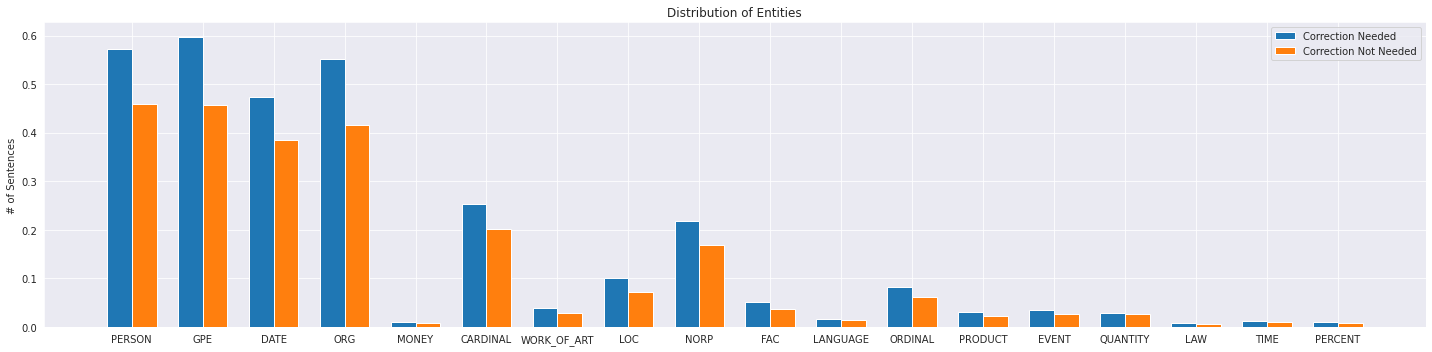

In [ ]:
labels = Labels
correction_means = Fin[0]
non_correction = Fin[1]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (20,5))
rects1 = ax.bar(x - width/2, correction_means, width, label='Correction Needed')
rects2 = ax.bar(x + width/2, non_correction, width, label='Correction Not Needed')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of Sentences')
ax.set_title('Distribution of Entities')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
path_to_save = '/content/drive/Shareddrives/MADS_Milestone2_Drive/Images/NER.png'
fig.savefig(path_to_save,dpi = 100)

## Add Dale Chally

Experiment 2 : Using Dale Chally set, find the proportion of words that are easy to interpret

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['tagger','parser','ner'])
#nlp.pipe_names
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['tagger','parser','ner'])
#nlp.pipe_names
nlp.add_pipe(nlp.create_pipe('sentencizer'))

def lemmatize(doc):
  doc_list =  [str(tok).lower() for tok in doc
                   if tok.is_alpha and tok.text.lower() in dale_chall]
  doc_vals =  [str(tok).lower() for tok in doc
                   if tok.is_alpha]

  if len(doc_vals) ==0:
    val = 99
  else:
    val = len(doc_list)/len(doc_vals) 
  return val
def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        #preproc_pipe.append(lemmatize_pipe(doc))
        preproc_pipe.append(lemmatize(doc))
    return preproc_pipe

def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=7, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(texts),chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

train_df_1['DALE_CHALLY_PCT'] = preprocess_parallel(train_df_1['original_text'],chunksize = 10000)
test_df_1['DALE_CHALLY_PCT'] = preprocess_parallel(test_df_1['original_text'],chunksize = 10000)

In [ ]:
train_df_1[train_df_1['DALE_CHALLY_PCT']<99].groupby('label').mean()['DALE_CHALLY_PCT']

label
0    0.564428
1    0.551798
Name: DALE_CHALLY_PCT, dtype: float64

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


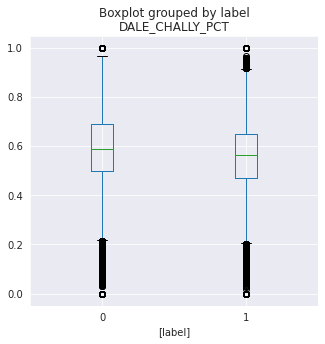

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
boxplot = train_df_1[train_df_1['DALE_CHALLY_PCT']<99].boxplot(column=['DALE_CHALLY_PCT'],by = ['label'],ax = ax)

In [ ]:
path_to_save = '/content/drive/Shareddrives/MADS_Milestone2_Drive/Images/DaleChall.png'
fig.savefig(path_to_save,dpi = 100)

Looks like Dale Chally has no / little impact on the sentence correction. While in a general sense, 29% of the words / tokens in text are familiar in Sentences that need completeness - It may not hold true statistically

## Add Avg. Age of Acquisition information

In [ ]:
AOA_DICT = AOA_SUB.set_index('Alternative.spelling').to_dict()['AoA_Kup_lem']

In [ ]:
def AOA_ADDER(doc):
  doc_list =  [AOA_DICT[str(tok).lower()] for tok in doc
                   if tok.text.lower() in AOA_DICT.keys()]
  if len(doc_list)>0:
    return np.mean(doc_list)
  else:
    return 99

In [ ]:
def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        #preproc_pipe.append(lemmatize_pipe(doc))
        preproc_pipe.append(AOA_ADDER(doc))
    return preproc_pipe

In [ ]:
def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

In [ ]:
def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

In [ ]:
def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=7, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(train_df_1), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

In [ ]:
train_df_1['MEAN_AOA'] = preprocess_parallel(train_df_1['original_text'],chunksize = 10000)
#test = preprocess_parallel(train_df_1['original_text'].head(5),chunksize = 10000)

In [ ]:
train_df_1[train_df_1['MEAN_AOA']<99].groupby('label').mean()['MEAN_AOA']

label
0    5.739216
1    5.901825
Name: MEAN_AOA, dtype: float64

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


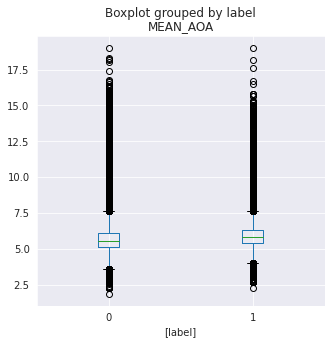

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
boxplot = train_df_1[train_df_1['MEAN_AOA']<99].boxplot(column=['MEAN_AOA'],by = ['label'],ax = ax)

In [ ]:
path_to_save = '/content/drive/Shareddrives/MADS_Milestone2_Drive/Images/AoA.png'
fig.savefig(path_to_save,dpi = 100)

A very similar learning rate observed between both the labels - Indicating AoA is not really distinguishing these two sentences

## Incorporate Correctness factors

In [ ]:
concrenteness_dict = concreteness.set_index('Word').to_dict()['Percent_known']

In [ ]:
def CORECTNESS_ADDER(doc):
  doc_list =  [concrenteness_dict[str(tok).lower()] for tok in doc
                   if tok.text.lower() in concrenteness_dict.keys()]
  doc_list_denum =  [str(tok).lower() for tok in doc
                   if tok.text.lower() not in concrenteness_dict.keys()]
  #bigrm = [' '.join(i) for i in list(nltk.bigrams(doc))]
  #val_list =  [concrenteness_dict[val.lower()] for val in bigrm
  #                 if val.lower() in concrenteness_dict.keys()]
  #doc_list.extend(val_list)
  return len(doc_list)/(len(doc_list)+len(doc_list_denum))

In [ ]:
def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        #preproc_pipe.append(lemmatize_pipe(doc))
        preproc_pipe.append(CORECTNESS_ADDER(doc))
    return preproc_pipe

In [ ]:
def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

In [ ]:
def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

In [ ]:
def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=7, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(train_df_1), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

In [ ]:
train_df_1['CONCRETENESS_PCT'] = preprocess_parallel(train_df_1['original_text'],chunksize = 10000)
#test = preprocess_parallel(train_df_1['original_text'].head(5),chunksize = 10000)

In [ ]:
train_df_1.groupby('label').mean()['CONCRETENESS_PCT']

label
0    0.603471
1    0.610819
Name: CONCRETENESS_PCT, dtype: float64

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


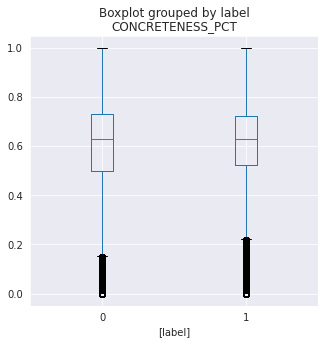

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
boxplot = train_df_1.boxplot(column=['CONCRETENESS_PCT'],by = ['label'],ax = ax)

In [ ]:
path_to_save = '/content/drive/Shareddrives/MADS_Milestone2_Drive/Images/Concreteness.png'
fig.savefig(path_to_save,dpi = 100)

In [ ]:
#Import datasets
train_df_1.to_csv('/content/drive/Shareddrives/MADS_Milestone2_Drive/Data/New Features/Training_Final.csv')

# Summary

While there are multiple sources shared by the team, there is no significant differences in profiles of the sentences in contention. Standing at this point, we have two alternatives to look for 

*   Does that mean, we have to investigate the inherent sequences of the words in the sentence? (We are not exploring this as requires computational power)
*   Does that mean, we have to see other variables like Parts of Speech, TFIDF vectors? (Please stay tuned for the Step1_Feature_Engineering_Part2 notebook

In [ ]:
!pip install watermark

In [ ]:
%reload_ext watermark
%watermark
%watermark --iversions

Last updated: 2021-09-26T10:06:35.007954+00:00

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

google    : 2.0.3
matplotlib: 3.2.2
sklearn   : 0.0
scipy     : 1.4.1
IPython   : 5.5.0
chardet   : 3.0.4
numpy     : 1.19.5
logging   : 0.5.1.2
re        : 2.2.1
seaborn   : 0.11.2
nltk      : 3.2.5
pandas    : 1.1.5
spacy     : 2.2.4
sys       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
json      : 2.0.9
gensim    : 3.6.0



In [ ]:
train_df_1[train_df_1['label']==1].original_text.values

array(["There is manuscript evidence that Austen continued to work on these pieces as late as the period 1809 â '' 11 , and that her niece and nephew , Anna and James Edward Austen , made further additions as late as 1814 .",
       "In a remarkable comparative analysis , Mandaean scholar Säve-Söderberg demonstrated that Mani 's Psalms of Thomas were closely related to Mandaean texts .",
       'Before Persephone was released to Hermes , who had been sent to retrieve her , Hades tricked her into eating pomegranate seeds , -LRB- six or three according to the telling -RRB- which forced her to return to the underworld for a period each year .',
       ...,
       'Euptoieta is a genus of butterflies in the subfamily Heliconiinae .',
       'Bar Kokhba revolt -LRB- 132 135 -RRB- -- also called the Second Jewish-Roman War -LRB- when Kitos War is not counted -RRB- , or the Third -LRB- when the Kitos War is counted -RRB- .',
       'Enhanced vaccination efforts led by the World Health Organiz